In [25]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')
import importlib 
import kernel_hypernet as kernel_hypernet
import var_net as var_net
import utils as utils0
importlib.reload(utils0)
import mnist_utils as utils
importlib.reload(utils)

importlib.reload(var_net)
importlib.reload(kernel_hypernet)
import importlib 
import var_net as var_net
import base_net as base_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(base_net)



import linear_var_hypernet as linear_var_hypernet

In [26]:
import seaborn as sns
sns.set('paper', style='white', font_scale=1.5)
plt.rcParams['figure.figsize'] = (7,4.5)

In [27]:
from sklearn.datasets import load_wine
from torch.utils.data import TensorDataset, DataLoader
wine_X , wine_Y = load_wine(return_X_y=True)
device = 'cpu'
rs = np.random.RandomState(42)
ids = list(range(len(wine_X)))
rs.shuffle(ids)

train_X, test_X = wine_X[ids[:len(ids)*4//5]], wine_X[ids[len(ids)*4//5:]]
train_Y, test_Y = wine_Y[ids[:len(ids)*4//5]], wine_Y[ids[len(ids)*4//5:]]

mean = np.mean(train_X, 0)
std = np.std(train_X, 0)

train_X = (train_X - mean)/std
test_X = (test_X - mean)/std




train_X = t.tensor(train_X).to(device)
test_X = t.tensor(test_X).to(device)
train_Y = t.tensor(train_Y).to(device)
test_Y = t.tensor(test_Y).to(device)


train_data = TensorDataset(train_X.float(),train_Y)
train_loader = DataLoader(train_data) 

test_data = TensorDataset(test_X.float(),test_Y)
test_loader = DataLoader(test_data) 

        

In [28]:
init_log_sigma = -3.0
params = {}
params_linear = {}
params_kernel = {}

acc = {}
acc_linear = {}
acc_kernel = {}

lambda_encode = lambda x: (t.log(x) - np.log(100.0))/(np.log(10**6) - np.log(100.0))



lamb = [10**2, 10**3, 10**4, 10**5, 10**6]
#lamb = [t.tensor(l) for l in lamb]
device = 'cpu'
prior_sigma = 1.0
net = var_net.VarNet(var_net.VarLayer(13, 3, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x))


for l in lamb:
    params[l] = []
    acc[l] = []
    for i in range(5):
        net.load_state_dict(t.load('./saved_wine/rep_net_lam_{}_start_{}.cpk'.format(l, i)))
        params[l].append((net[0].mean.cpu().detach().numpy().copy(), net[0].log_sigma.cpu().detach().numpy().copy()))
        net.eval()
        acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        
        
net = var_net.VarNet( linear_var_hypernet.VarLayerLinearAppr(13, 3,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))


for l in lamb:    
    params_linear[l] = []
    acc_linear[l] = []
    for i in range(5):    
        net.load_state_dict(t.load('./saved_wine/rep_linear_start_{}.cpk'.format(i)))
        net.eval()
        params_linear[l].append((net[0].mean(lambda_encode(t.tensor(l))).detach().numpy().copy(), net[0].log_sigma(lambda_encode(t.tensor(l))).detach().numpy().copy()))
        acc_linear[l].append( ((1.0*t.eq(net(test_X.float(), lambda_encode(t.tensor(l))).argmax(1), test_Y)).mean().item()))

for k in range(2,6):
    params_kernel[k] = {}
    acc_kernel[k] = {}
    for l in lamb:
        params_kernel[k][l] = []
        acc_kernel[k][l] = []
        

for k in [3,5]:    
    net = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   k, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
    for l in lamb:        
        for i in range(5):
            net.load_state_dict(t.load('./saved_wine/rep_kernel_{}_start_{}.cpk'.format(k, i)))
            net.eval()
            params_kernel[k][l].append((net[0].mean(lambda_encode(t.tensor(l))).detach().numpy().copy(),
                                      net[0].log_sigma(lambda_encode(t.tensor(l))).detach().numpy().copy()))
            acc_kernel[k][l].append( ((1.0*t.eq(net(test_X.float(), lambda_encode(t.tensor(l))).argmax(1), test_Y)).mean().item()))
        

/home/leginpc/reps/VarHyperNet/code/wine/../src/var_net.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)


In [29]:
def dist(q, p=None):
    if p is None:
        p = (0.0, 0.0)
    d1 = t.distributions.Normal(t.tensor(q[0]), t.exp(2*t.tensor(q[1])))
    d2 = t.distributions.Normal(t.tensor(p[0]), t.exp(2*t.tensor(p[1])))
    return (t.distributions.kl_divergence(d1,d2) * 0.5 + t.distributions.kl_divergence(d2,d1) * 0.5).sum()


[-5.144203, -9.045512, -11.334314, -15.175687, -15.516907] [0.9499999761581421, 0.9444444179534912, 0.6833333253860474, 0.7388888835906983, 0.41666666269302366]


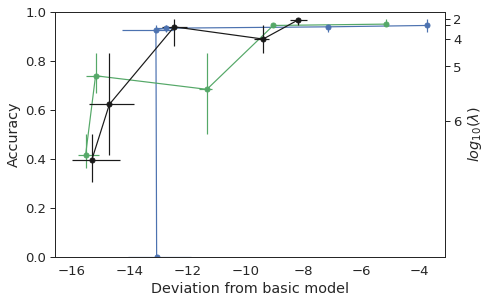

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

### nets
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc[l][i])
    #plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
    #             yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], marker='.', c='r', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
#plt.plot(X, Y, c='r')
ax2.set_yticks(Y)
ax2.set_yticklabels(['2', '', '4', '5', '6'])    
    

# linear
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_linear[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_linear[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='b', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
    
plt.plot(X, Y, c='b',label= 'linear model') 


# kernel-3
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel[3][l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel[3][l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='g', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
print (X, Y)
    
plt.plot(X, Y, c='g', label=  'piecewise-linear model, k=3')      


# kernel-5
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel[5][l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel[5][l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='k', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
plt.plot(X, Y, c='k', label=  'piecewise-linear model, k=5')       

plt.ylim((0, 1))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Deviation from basic model')
ax2.set_ylabel('$log_{10}(\lambda)$')
#ax2.set_ylabel('sin', color='r')


plt.savefig('wine_net_1.png', bbox_inches='tight')



In [21]:
LR = 5e-4
E = 142//16

params_linear2 = {}
acc_linear2 = {}

params_kernel32 = {}
acc_kernel32 = {}

params_kernel52 = {}
acc_kernel52 = {}

params2 = {}
acc2 = {}

net = var_net.VarNet(var_net.VarLayer(13, 3, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x))

for l in lamb:
    params2[l] = []
    acc2[l] = []
    for i in range(5):
        net.load_state_dict(t.load('./saved_wine/rep_net_lam_{}_start_{}.cpk'.format(l, i)))
        params2[l].append((net[0].mean.cpu().detach().numpy().copy(), net[0].log_sigma.cpu().detach().numpy().copy()))
        net.eval()
        acc2[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        
        
# linear
net0 = var_net.VarNet( linear_var_hypernet.VarLayerLinearAppr(13, 3,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
for l in lamb:
    params_linear2[l] = []
    acc_linear2[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/rep_linear_start_{}.cpk'.format(i)))
        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)   
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l), 'fine linear '+str(i)+' ', batch_num=E, rep=True)        
        net.eval()
        acc_linear2[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_linear2[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

net0 = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   3, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))              
for l in lamb:
    params_kernel32[l] = []
    acc_kernel32[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/rep_kernel_3_start_{}.cpk'.format(i)))        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)       
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l),  'fine kernel3 '+str(i)+' ', batch_num=E, rep=True)            
        net.eval()
        acc_kernel32[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_kernel32[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

net0 = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   5, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

for l in lamb:
    params_kernel52[l] = []
    acc_kernel52[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/rep_kernel_5_start_{}.cpk'.format(i)))        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)       
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l),  'fine kernel5 '+str(i)+' ', batch_num=E, rep=True)             
        net.eval()
        acc_kernel52[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_kernel52[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

            

/home/leginpc/reps/VarHyperNet/code/wine/../src/var_net.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

[-2.2964416, -0.5577759, -12.251423, -14.288727, -16.551735] [0.9444444179534912, 0.9444444179534912, 0.794444465637207, 0.8944444537162781, 0.5666666686534881]
[-2.221436, -0.6210129, -12.459457, -14.197436, -16.404982] [0.9611110925674439, 0.8777777910232544, 0.8222222328186035, 0.85, 0.6444444417953491]


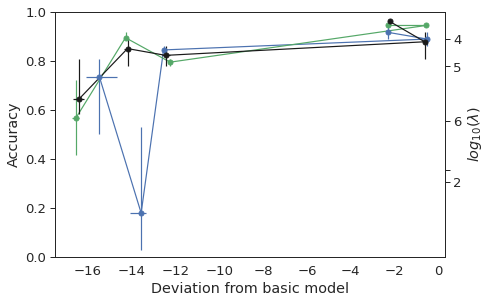

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


### nets
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc[l][i])
    #plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
    #             yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], marker='.', c='r', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
#plt.plot(X, Y, c='r')
ax2.set_yticks(Y)
ax2.set_yticklabels(['2', '', '4', '5', '6'])  


# linear
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_linear2[l][i],  params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_linear2[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='b', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
    
plt.plot(X, Y, c='b')    

# kernel-3
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel32[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel32[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='g', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
print (X, Y)
    
plt.plot(X, Y, c='g')    


# kernel-5
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel52[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel52[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='k', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
print (X, Y)
plt.plot(X, Y, c='k') 

plt.ylim((0, 1))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Deviation from basic model')
ax2.set_ylabel('$log_{10}(\lambda)$')
#ax2.set_ylabel('sin', color='r')


plt.savefig('wine_base_1.png', bbox_inches='tight')






In [23]:
LR = 5e-4
E = 142

params_linear2 = {}
acc_linear2 = {}

params_kernel32 = {}
acc_kernel32 = {}

params_kernel52 = {}
acc_kernel52 = {}

params2 = {}
acc2 = {}

net = var_net.VarNet(var_net.VarLayer(13, 3, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x))

for l in lamb:
    params2[l] = []
    acc2[l] = []
    for i in range(5):
        net.load_state_dict(t.load('./saved_wine/rep_net0_lam_{}_start_{}.cpk'.format(l, i)))
        params2[l].append((net[0].mean.cpu().detach().numpy().copy(), net[0].log_sigma.cpu().detach().numpy().copy()))
        net.eval()
        acc2[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        
        
# linear
net0 = var_net.VarNet( linear_var_hypernet.VarLayerLinearAppr(13, 3,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
for l in lamb:
    params_linear2[l] = []
    acc_linear2[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/rep_linear_start_{}.cpk'.format(i)))
        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)   
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l), 'fine linear '+str(i)+' ', batch_num=E, rep=True)        
        net.eval()
        acc_linear2[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_linear2[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

net0 = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   3, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))              
for l in lamb:
    params_kernel32[l] = []
    acc_kernel32[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/var_kernel_3_start_{}.cpk'.format(i)))        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)       
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l),  'fine kernel3 '+str(i)+' ', batch_num=E, rep=True)    
        net.eval()
        acc_kernel32[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_kernel32[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

net0 = var_net.VarNet(kernel_hypernet.VarKernelLayer(13, 3,   5, 
                                                    prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

for l in lamb:
    params_kernel52[l] = []
    acc_kernel52[l] = []
    for i in range(5):
        net0.load_state_dict(t.load('./saved_wine/var_kernel_5_start_{}.cpk'.format(i)))        
        utils0.net_copy(net0, net, lambda_encode(t.tensor(l)), layer_num=1, mode='var')
        #acc[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        optim = t.optim.Adam(net.parameters(), lr=LR)
        loss_fn = nn.CrossEntropyLoss().to(device)       
        
        utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(l),  'fine kernel5 '+str(i)+' ', batch_num=E, rep=True)     
        net.eval()
        acc_kernel52[l].append( ((1.0*t.eq(net(test_X.float()).argmax(1), test_Y)).mean().item()))
        net.train()
        params_kernel52[l].append((net[0].mean.detach().numpy().copy(), net[0].log_sigma.detach().numpy().copy()))

            

/home/leginpc/reps/VarHyperNet/code/wine/../src/var_net.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

[-0.26873603, -0.2825481, -0.28428754, -0.28416747, -0.28405723] [0.9444444179534912, 0.9222222208976746, 0.9222222089767456, 0.7944444298744202, 0.5555555522441864]
[-0.31718534, -0.26904187, -0.28546435, -0.28412133, -0.28398928] [0.9388888716697693, 0.9166666626930237, 0.9222222089767456, 0.8611111044883728, 0.35]


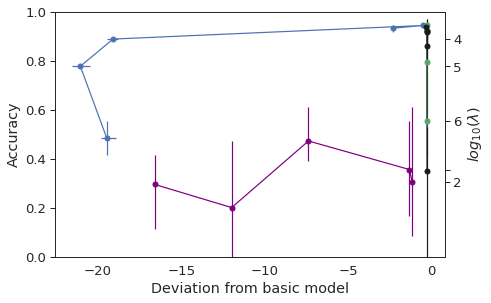

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


### nets
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc[l][i])
    #plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
    #             yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], marker='.', c='r', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
#plt.plot(X, Y, c='r')
ax2.set_yticks(Y)
ax2.set_yticklabels(['2', '', '4', '5', '6'])  


### nets
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params2[l][i], params2[l][j])
        x.append(np.log(x_/denon))
        y.append(acc2[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], marker='.', c='purple', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
plt.plot(X, Y, c='purple')

# linear
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_linear2[l][i],  params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_linear2[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='b', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
    
plt.plot(X, Y, c='b')    

# kernel-3
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel32[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel32[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='g', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
print (X, Y)
    
plt.plot(X, Y, c='g')    


# kernel-5
X = []
Y = []
for l in lamb:    
    denon = 0
    x = []
    y = []
    for i in range(5):
        denon += dist(params[l][i])
    for i in range(5):
        x_ = 0 
        for j in range(5):
            x_ += dist(params_kernel52[l][i], params[l][j])
        x.append(np.log(x_/denon))
        y.append(acc_kernel52[l][i])
    plt.errorbar([np.mean(x)], [np.mean(y)], xerr =[[np.mean(x) - np.min(x)], [np.max(x) - np.mean(x) ]],
                 yerr = [[np.mean(y) - np.min(y)], [np.max(y) - np.mean(y)]], c='k', marker='.', markersize=10)
    X.append(np.mean(x))
    Y.append(np.mean(y))
print (X, Y)
plt.plot(X, Y, c='k') 

plt.ylim((0, 1))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Deviation from basic model')
ax2.set_ylabel('$log_{10}(\lambda)$')
#ax2.set_ylabel('sin', color='r')


plt.savefig('wine_base_1.png', bbox_inches='tight')






/tmp/ipykernel_5610/2742663401.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+['base model', 'linear','linear + fine-tune', 'piece-wise', 'piece-wise + fine-tune'])


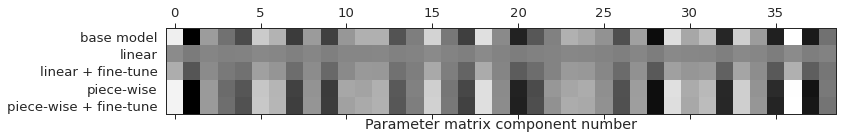

In [262]:
plt.rcParams['figure.figsize'] = (12,9)
figure = plt.figure()
axes = figure.add_subplot(111)

matrix1 = np.vstack([params[100][0].flatten(), params_linear[100][0].flatten(),  params_linear2[100][0].flatten(), params_kernel[5][100][0].flatten(),  params_kernel52[100][0].flatten()])
axes.matshow(matrix1, cmap='gray')
plt.xlabel('Parameter matrix component number')
#ax.set_yticklabels([])
axes.set_yticklabels(['']+['base model', 'linear','linear + fine-tune', 'piece-wise', 'piece-wise + fine-tune'])


plt.savefig('wine_matrix1.png', bbox_inches='tight')


/tmp/ipykernel_5610/476825305.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+['base model', 'linear','linear + fine-tune', 'piece-wise', 'piece-wise + fine-tune'])


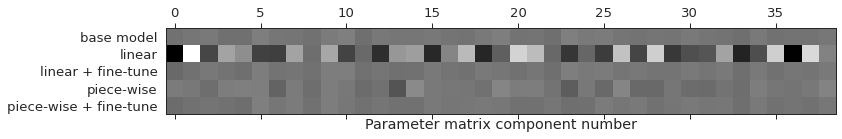

In [263]:
plt.rcParams['figure.figsize'] = (12,9)
figure = plt.figure()
axes = figure.add_subplot(111)

matrix1 = np.vstack([params[1000000][0].flatten(), params_linear[1000000][0].flatten(),  params_linear2[1000000][0].flatten(), params_kernel[5][1000000][0].flatten(),  params_kernel52[1000000][0].flatten()])
axes.matshow(matrix1, cmap='gray')
plt.xlabel('Parameter matrix component number')
#ax.set_yticklabels([])
axes.set_yticklabels(['']+['base model', 'linear','linear + fine-tune', 'piece-wise', 'piece-wise + fine-tune'])
plt.savefig('wine_matrix2.png', bbox_inches='tight')